In [1]:
# Building Seq2Seq LSTM with Luong Attention in Keras for Time Series Forecasting

In [2]:
# https://levelup.gitconnected.com/
# building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
import pydot as pyd

In [3]:
import keras
from keras.models import Sequential, Model, load_model

In [4]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization
from keras.layers import multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model, model_to_dot

In [5]:
keras.utils.vis_utils.pydot = pyd

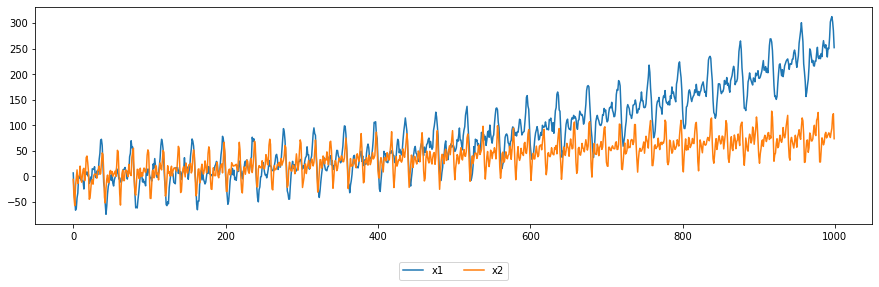

In [8]:
# create some data
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern (sine waves) + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [9]:
# split sequences to 80% train set and 20% test set

In [10]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

800


In [11]:
# detrending x1 and x2

In [12]:
# get and index for time step variable at x1 and x2
x_index = np.array(range(len(t)))

In [13]:
# polyfit x1 as second order and x2 as first order, get coefficients
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.45223383e-04  5.10526437e-03 -1.21600755e+00]
[ 0.08146957 -1.14208017]


In [14]:
# get trend curves (second and first order)
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

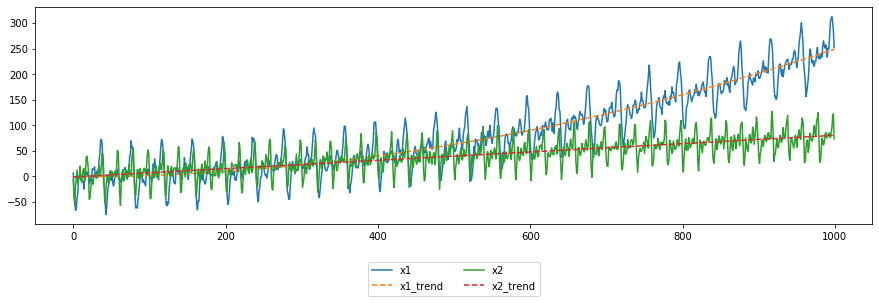

In [15]:
# Let’s plot the trend lines together with x1 and x2, and check if they look good.
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

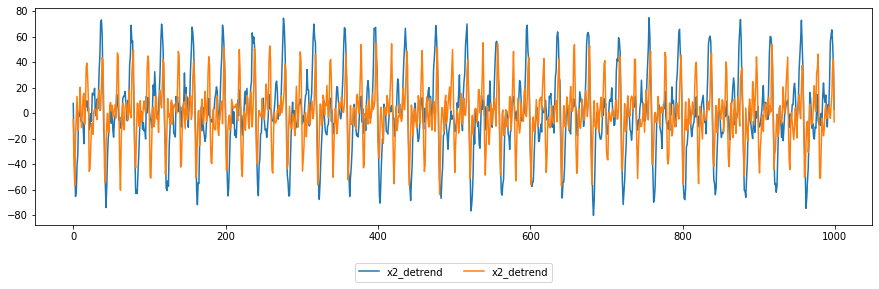

In [16]:
# deduct the trend
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [17]:
# For easier preprocessing in next several steps, we can combine the sequences
# and their relevant information together into one array.

In [18]:
# [x1_detrend, x2_detrend, x_index, label (1:train, 0:test)]
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  7.64541896  -5.03093638   0.           1.        ]
 [-28.89212189 -40.56661128   1.           1.        ]
 [-42.37695589 -56.59636793   2.           1.        ]
 ...
 [ 54.68227835  37.17621466 997.           0.        ]
 [ 36.71777963  42.25223631 998.           0.        ]
 [  3.15356017  -6.76790602 999.           0.        ]]


In [19]:
# normalize data
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[74.76295735748346, 55.200359176293915, 1, 1]


In [20]:
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[ 1.02262126e-01 -9.11395587e-02  0.00000000e+00  1.00000000e+00]
 [-3.86449693e-01 -7.34897596e-01  1.00000000e+00  1.00000000e+00]
 [-5.66817544e-01 -1.02528985e+00  2.00000000e+00  1.00000000e+00]
 ...
 [ 7.31408712e-01  6.73477767e-01  9.97000000e+02  0.00000000e+00]
 [ 4.91122622e-01  7.65434083e-01  9.98000000e+02  0.00000000e+00]
 [ 4.21807842e-02 -1.22606195e-01  9.99000000e+02  0.00000000e+00]]


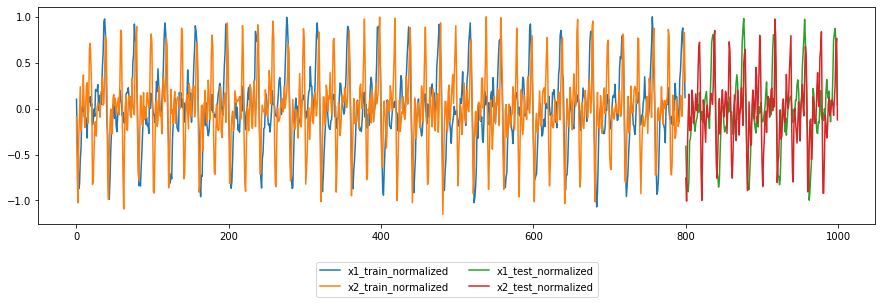

In [21]:
# plot normalized data
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

In [22]:
# apply a sliding window, input sequence size is 200, output sequence size is 20

In [23]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [24]:
# X_in has three columns:
# detrended and normalised x1,
# detrended and normalised x2, and
# original assigned data position index

In [25]:
# X_out has three columns
# detrended and normalised x1,
# detrended and normalised x2, and
# original assigned data position index

In [26]:
# lbl (label) has one column: 1 for train set and 0 for test set

In [27]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


In [28]:
# Model 1: Simple Seq2Seq LSTM Model

The encoder LSTM cell: The value of each time step is input into the encoder LSTM cell together with previous cell state c and hidden state h, the process repeats until the last cell state c and hidden state h are generated.

The decoder LSTM cell: We use the last cell state c and hidden state h from the encoder as the initial states of the decoder LSTM cell. The last hidden state of encoder is also copied 20 times, and each copy is input into the decoder LSTM cell together with previous cell state c and hidden state h. The decoder outputs hidden state for all the 20 time steps, and these hidden states are connected to a dense layer to output the final result.

In [29]:
# set the number of hidden layers
n_hidden = 100

In [30]:
# The input layer

In [31]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)


In [32]:
# The encoder LSTM

We need to pay attention to 2 import parameters return_sequences and return_state, because they decide what LSTM returns.

return_sequences=False, return_state=False: returns only the last hidden state: last_state_h

return_sequences=True, return_state=False: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step

return_sequences=False, return_state=True: return 3 arrays: last_state_h, and last_state_h, last_state_c (last_state_h is the default result, then the last hidden state and the last cell state)

return_sequences=True, return_state=True: return 3 arrays: stacked hidden states, last state_h, last state_c

See https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

After completing this tutorial, you will know:

That return sequences return the hidden state output for each input time step.

That return state returns the hidden state output and cell state for the last input time step.

That return sequences and return state can be used at the same time.

In [33]:
# For simple Seq2Seq model, we only need last hidden state and last cell state: last_state_h, last_state_c.
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
    return_sequences=False, return_state=True)(input_train)

print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

Tensor("lstm/strided_slice_3:0", shape=(None, 100), dtype=float32)
Tensor("lstm/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm/while:5", shape=(None, 100), dtype=float32)


In [34]:
# Batch normalisation is added because we want to avoid gradient explosion caused
# by the activation function ELU in the encoder.
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

Next, we make 20 copies of the last hidden state of encoder and use them as input to the decoder.

The last cell state and the last hidden state of the encoder are also used as the initial states of decoder.

In [35]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)

decoder = LSTM(n_hidden,
               activation='elu',
               dropout=0.2,
               recurrent_dropout=0.2,
               return_state=False,
               return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

print(decoder)

Tensor("lstm_1/transpose_1:0", shape=(None, 20, 100), dtype=float32)


the decoder returns sequences, that means it returns 20 hidden states, each one is a 100-d vector,
and each one is related to a timestep in the output 

Keras TimeDistributed is now used to separatedly pass a Dense to each one of the 100-d hidden, to get the two features x1, x2

In [36]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

print(out)

Tensor("time_distributed/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [37]:
# build the model: Adam optimezer, train loss is MSE, evaluation metric is MAE

In [38]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
_______________________________________________________________________________________

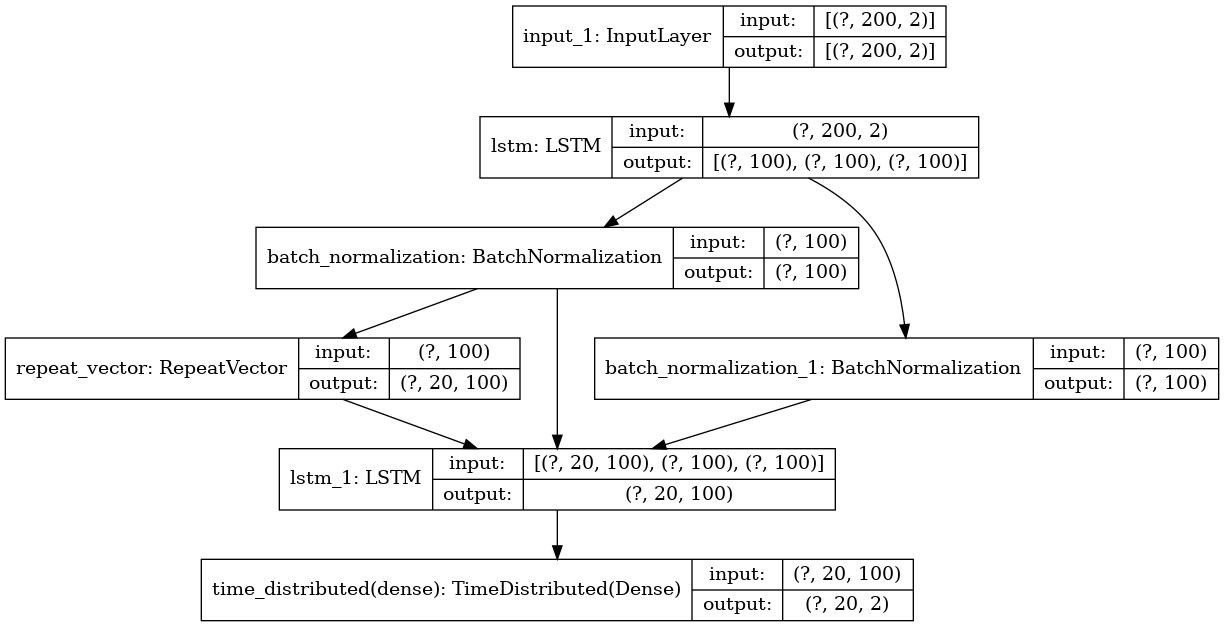

In [39]:
# plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
# now train the model and save it
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 2s 379ms/step - loss: 3.0079 - mae: 0.9901 - val_loss: 0.1899 - val_mae: 0.3363
Epoch 2/100
5/5 [==============================] - 1s 270ms/step - loss: 0.2003 - mae: 0.3402 - val_loss: 0.1595 - val_mae: 0.2949
Epoch 3/100
5/5 [==============================] - 1s 266ms/step - loss: 0.1607 - mae: 0.2977 - val_loss: 0.1461 - val_mae: 0.2776
Epoch 4/100
5/5 [==============================] - 1s 276ms/step - loss: 0.1483 - mae: 0.2823 - val_loss: 0.1372 - val_mae: 0.2682
Epoch 5/100
5/5 [==============================] - 1s 267ms/step - loss: 0.1398 - mae: 0.2724 - val_loss: 0.1293 - val_mae: 0.2587
Epoch 6/100
5/5 [==============================] - 1s 273ms/step - loss: 0.1380 - mae: 0.2709 - val_loss: 0.1245 - val_mae: 0.2554
Epoch 7/100
5/5 [==============================] - 1s 286ms/step - loss: 0.1339 - mae: 0.2668 - val_loss: 0.1236 - val_mae: 0.2574
Epoch 8/100
5/5 [==============================] - 1s 297ms/step - loss: 0.1303 - m

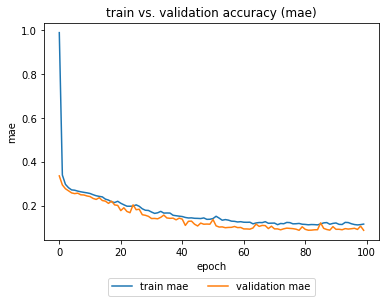

In [41]:
# plot training metrics
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Prediction

The model prediction as well as the true values are unnormalised:

In [42]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


Then we combine the unnormalised outputs with their corresponding index, so that we can recover the trend.

In [43]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


Next, we put all the outputs with recovered trend into a dictionary data_final.

In [44]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


In [45]:
# Just a quick check to see if the prediction value distribution is reasonable:

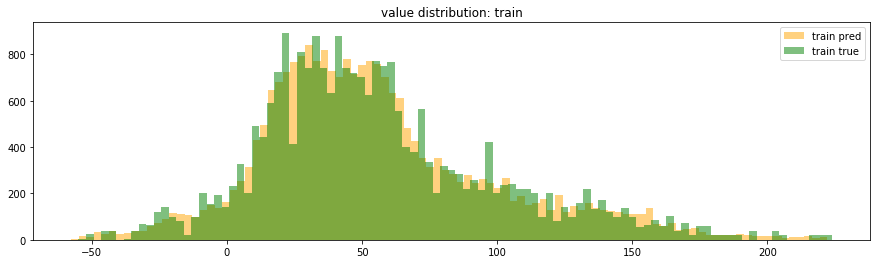

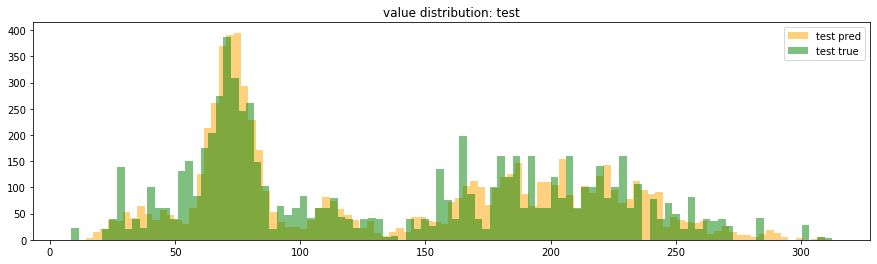

In [46]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

The data distribution of prediction and true values are almost overlapped, so we are good.

We can also plot MAE of all samples in time order, to see if there is clear pattern. The ideal situation is when line is random, otherwise it may indicate that the model is not sufficiently trained.

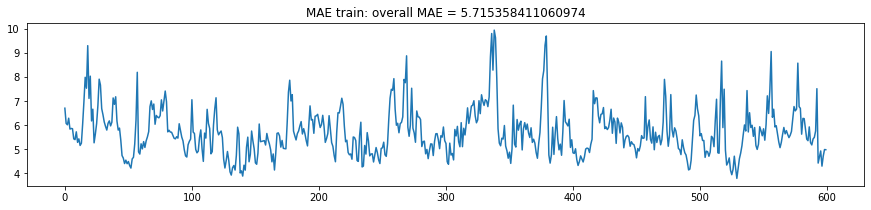

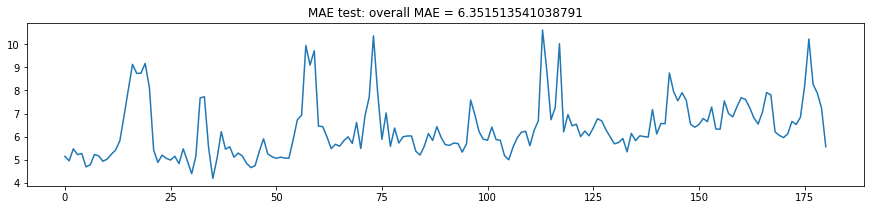

In [47]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

Based on the above plots, we can say that there are still certain periodical pattens in both train and test MAE. Training for more epochs may lead to better results.

Next we are going to check some random samples and see if the predicted lines and corresponding true lines are aligned. See the plots in the blog entry.


We can also check the nth prediction of each time step:

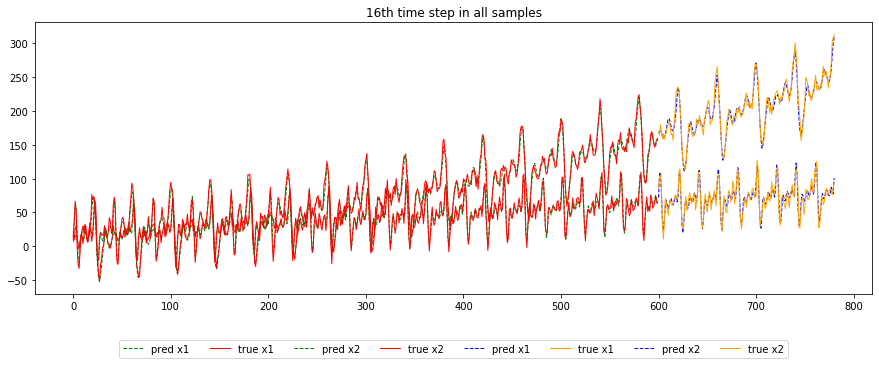

In [48]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

Take a closer look at the prediction on test set:

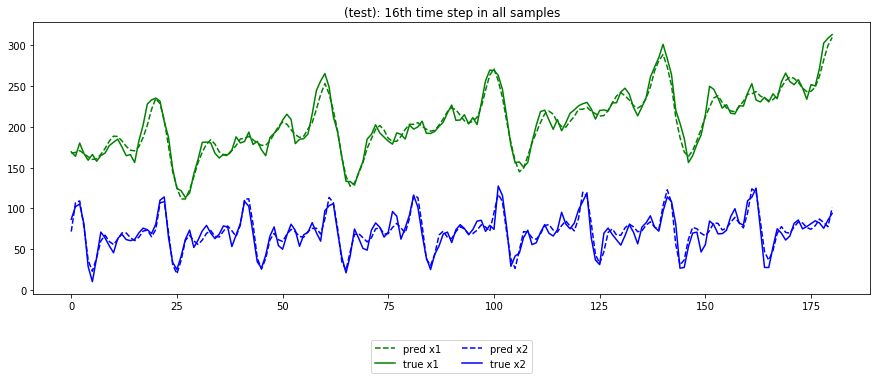

In [49]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Model 2: Seq2Seq LSTM Model with Luong Attention

View the differences between Luong Attention and Bahdanau Attention here:

https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb

One of the limitations of simple Seq2Seq model is: only the last state of encoder RNN is used as input to decoder RNN. If the sequence is very long, the encoder will tend to have much weaker memory about earlier time steps. Attention mechanism can solve this problem. An attention layer is going to assign proper weight to each hidden state output from encoder, and map them to output sequence.
Next we will build Luong Attention on top of Model 1, and use Dot method to calculate alignment score.

The Input layer is the same as in Model 1:

In [52]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

print(input_train)
print(output_train)

Tensor("input_5:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_6:0", shape=(None, 20, 2), dtype=float32)


The encoder LSTM

This is slightly different from Model 1: besides returning the last hidden state and the last cell state, we also need to return the stacked hidden states for alignment score calculation.

In [53]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
     return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

Tensor("lstm_3/transpose_1:0", shape=(None, 200, 100), dtype=float32)
Tensor("lstm_3/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm_3/while:5", shape=(None, 100), dtype=float32)


Next, we apply batch normalisation to avoid gradient explosion.

In [54]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

The Decoder LSTM

Next, we repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.

In [55]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

Tensor("repeat_vector_1/Tile:0", shape=(None, 20, 100), dtype=float32)


We also need to get the stacked hidden state of the decoder for alignment score calculation.

In [56]:
decoder_stack_h = LSTM(n_hidden, activation='elu',
                       dropout=0.2, recurrent_dropout=0.2,
                       return_state=False,
                       return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

print(decoder_stack_h)

Tensor("lstm_4/transpose_1:0", shape=(None, 20, 100), dtype=float32)


Attention Layer

To build the attention layer, the first thing to do is to calculate the alignment score, and apply softmax activation function over it:

In [57]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

Tensor("activation/truediv:0", shape=(None, 20, 200), dtype=float32)


Then we can calculate the context vector, and also apply batch normalisation on top of it:

In [58]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(None, 20, 100), dtype=float32)


Now we concat the context vector and stacked hidden states of decoder, and use it as input to the last dense layer.

In [59]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

Tensor("concatenate/concat:0", shape=(None, 20, 200), dtype=float32)


In [60]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)

print(out)

Tensor("time_distributed_1/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [61]:
# build the model
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 200, 100), ( 41200       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100)          400         lstm_3[0][1]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 100)      0           batch_normalization_2[0][0]      
_______________________________________________________________________________________

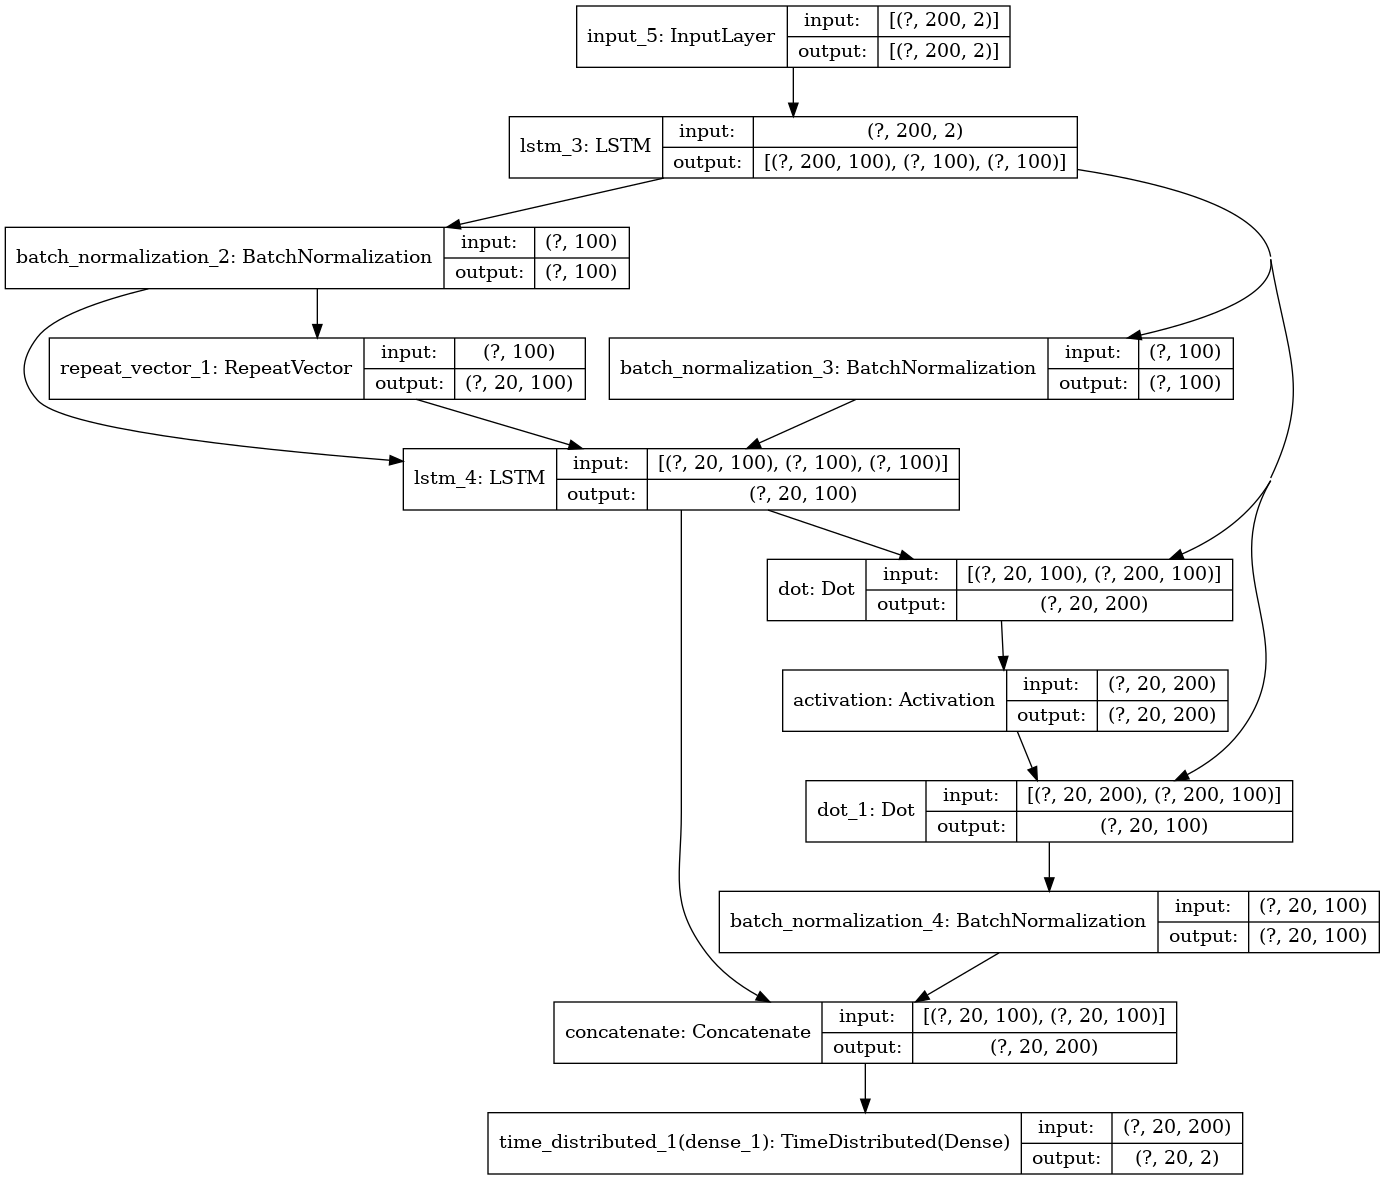

In [62]:
# plot the model
plot_model(model, to_file='model_attention_plot.png', show_shapes=True, show_layer_names=True)

In [63]:
# now train the model and save it
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq_attention.h5')

Epoch 1/100
5/5 [==============================] - 2s 408ms/step - loss: 2.2868 - mae: 0.8928 - val_loss: 0.1692 - val_mae: 0.3071
Epoch 2/100
5/5 [==============================] - 2s 314ms/step - loss: 0.1896 - mae: 0.3270 - val_loss: 0.1507 - val_mae: 0.2805
Epoch 3/100
5/5 [==============================] - 2s 314ms/step - loss: 0.1526 - mae: 0.2890 - val_loss: 0.2409 - val_mae: 0.3833
Epoch 4/100
5/5 [==============================] - 2s 318ms/step - loss: 0.1436 - mae: 0.2778 - val_loss: 0.1589 - val_mae: 0.2987
Epoch 5/100
5/5 [==============================] - 2s 307ms/step - loss: 0.1369 - mae: 0.2717 - val_loss: 0.1254 - val_mae: 0.2615
Epoch 6/100
5/5 [==============================] - 2s 309ms/step - loss: 0.1282 - mae: 0.2622 - val_loss: 0.1206 - val_mae: 0.2567
Epoch 7/100
5/5 [==============================] - 2s 306ms/step - loss: 0.1220 - mae: 0.2566 - val_loss: 0.1137 - val_mae: 0.2483
Epoch 8/100
5/5 [==============================] - 2s 305ms/step - loss: 0.1116 - m

In [ ]:
# load model to avoid re-training


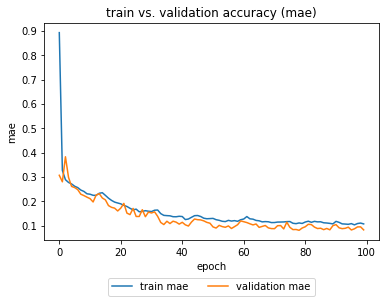

In [64]:
# plot training metrics
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()